In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import gc
# from keras.applications import DenseNet121
from tensorflow.keras.models import Model
# from tensorflow.keras import Input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Lambda, BatchNormalization
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
import os
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

import logging
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [ ]:
BASE_PATH = "/content/gdrive/MyDrive/KaggleDataBTP/gaussian_filtered_images/Pipeline_Model_testing/Model_1/"

In [ ]:
# logging.basicConfig(filename = "cro.log", level=logging.DEBUG, filemode='w+', format='%(name)s - %(levelname)s - %(message)s')

In [ ]:
def buildfinetunemodel():
    input = tf.keras.Input(shape=1024)
    x = tf.keras.layers.Activation(activation='relu')(input)
    x = tf.keras.layers.Dropout(0.5)(x)
    x= tf.keras.layers.Dense(1024,activation='relu')(x)
    x= tf.keras.layers.Dropout(0.5)(x)
    x= tf.keras.layers.Dense(1024)(x)
    output=tf.keras.layers.Dense(1,activation='sigmoid')(x)
    finetune_model = tf.keras.Model(input, output)
    finetune_model.compile(loss='binary_crossentropy',
                metrics=['accuracy'])


    return finetune_model

In [ ]:
finetune_model = buildfinetunemodel()
finetune_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1)                 1025  

In [ ]:
def change_label(x):
    if x == 1 or x == 2 or x == 3:
        return 1
    else:
        return 0

In [ ]:
data_x = np.load(BASE_PATH + "data_x.npy")
data_y = np.load(BASE_PATH + "data_y.npy")
data_y_binary = np.array([change_label(y) for y in data_y])
np.unique(data_y_binary, return_counts=True)

(array([0, 1]), array([1805, 1664]))

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y_binary, test_size = 0.15)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

print(np.unique(train_y, return_counts=True))
print(np.unique(test_y, return_counts=True))


(2948, 1024)
(2948,)
(521, 1024)
(521,)
(array([0, 1]), array([1521, 1427]))
(array([0, 1]), array([284, 237]))


In [ ]:
import random
import copy
import sys
import os
import sys
from tqdm import tqdm
import heapq

initializer = tf.keras.initializers.HeNormal()
vars = finetune_model.trainable_variables
loss_fn = tf.keras.losses.BinaryCrossentropy()
acc_fn = tf.keras.metrics.Accuracy()

num_molecule = 20
mole_coll = 0.3
KE_loss_rate = 0.1
buffer = 400

In [ ]:
class Molecule:
    def __init__(self, vars = None, weights = None, velocity = None, ke = None, num_hit = None, local_best = None):
        if weights:
            self.weights = weights
        elif vars:
            self.weights = [initializer(shape=s.shape) for s in vars]
        self.PE, self.acc = self.get_loss()

        if ke:
            self.KE = ke
        else:
            self.KE = 1

        self.TE = self.PE + self.KE
        self.val_loss, self.val_acc = self.get_loss_val()

        if velocity:
            self.velocity = velocity
        else:
            self.velocity = [tf.random.normal(shape=s.shape, stddev = 0.1) for s in vars] #, minval = -1, maxval=1

        self.num_hit = 0 # How many time the perticular molecule exploited its search space.

        self.local_best = self.weights

        self.gradient_average = [tf.zeros(shape=s.shape) for s in vars]

    def update_best(self):
        if self.PE < self.get_loss_weight(self.local_best)[0]:
            self.local_best = self.weights

    def update_PE(self):
        self.PE, self.acc = self.get_loss()
        self.val_loss, self.val_acc = self.get_loss_val()

    def get_loss_weight(self, weight):
        finetune_model.set_weights(weights=weight)
        logits = finetune_model(train_x)
        logits = tf.reshape(logits, (logits.shape[0], ))
        loss_value = loss_fn(train_y, logits)
        acc_value = accuracy_score(train_y, logits > 0.5)
        return loss_value, acc_value

    def get_loss(self):
        finetune_model.set_weights(weights=self.weights)
        logits = finetune_model(train_x)
        logits = tf.reshape(logits, (logits.shape[0], ))
        loss_value = loss_fn(train_y, logits)
        acc_value = accuracy_score(train_y, logits > 0.5)
        return loss_value, acc_value

    def get_loss_val(self):
        finetune_model.set_weights(weights=self.weights)
        logits = finetune_model(test_x)
        logits = tf.reshape(logits, (logits.shape[0], ))
        loss_value = loss_fn(test_y, logits)
        acc_value = accuracy_score(test_y, logits > 0.5)
        return loss_value, acc_value

    def reset_average(self):
        self.gradient_average = [tf.zeros(shape=s.shape) for s in vars]

In [ ]:
def create_molecule():
    m = Molecule(vars)
    m.velocity = [(global_best[i]- m.weights[i]) for i in range(len(global_best))]
    return m

def pso_update(m):
    r1 = random.random()
    r2 = random.random()
    first_term = [w*l_v for l_v in m.velocity]
    second_term = [c1*r1*x for x in [(m.local_best[i]- m.weights[i]) for i in range(len(m.local_best))]]
    third_term = [c2*r2*x for x in [(global_best[i]- m.weights[i]) for i in range(len(global_best))]]
    m.velocity = [m.KE * (first_term[i] + second_term[i] + third_term[i]) for i in range(len(first_term))]

    m.weights = [(m.weights[i]+ m.velocity[i]) for i in range(len(m.weights))]
    m.update_PE()
    m.num_hit = 0
    m.update_best()
    m.reset_average()
    if m.PE > 10:
        m = create_molecule()
    del first_term
    del second_term
    del third_term
    gc.collect()
    return m

def neighbourhood(m, learning_rate, momentum):

    with tf.GradientTape(watch_accessed_variables=False) as t:
        t.reset()
        t.watch(finetune_model.trainable_variables)
        finetune_model.set_weights(weights=m.weights)
        logits = finetune_model(train_x)
        logits = tf.reshape(logits, (logits.shape[0], ))
        loss_value = loss_fn(train_y, logits)

    gradients = t.gradient(loss_value, finetune_model.trainable_weights)

    for i in range(len(finetune_model.trainable_weights)):
        m.gradient_average[i] = momentum * m.gradient_average[i] + (1-momentum) * gradients[i]



    new_weights = []
    for i in range(len(finetune_model.trainable_weights)):
        layer = finetune_model.trainable_weights[i]
        layer =  layer - learning_rate * m.gradient_average[i]
        new_weights.append(layer)

    m.weights = new_weights
    m.update_PE()
    if m.PE > 10:
        m = create_molecule()
    del gradients
    del new_weights
    gc.collect()
    return m

def onwall_ineffective_collision(m):
    return neighbourhood(m, learning_rate, momemtum)

def onwall_criteria(m_old, m_new):
    pe_new = m_new.PE
    if (m_old.PE + m_old.KE >= pe_new):
        return True
    else:
        return False

def intermol_criteria(m1, m2, m1_new, m2_new):
    pe1 = m1_new.PE
    pe2 = m2_new.PE
    if (m1.PE + m1.KE + m2.PE + m2.KE >= pe1 + pe2):
        return True
    else:
        return False

def intermol_ineffective_collision(m1, m2):
    return (neighbourhood(m1, learning_rate, momemtum), neighbourhood(m2, learning_rate, momemtum)) #instead of creating new

def best_molecule():
    bm = molecule[0]
    for m in molecule:
        if m.PE < bm.PE:
            bm = m
    return bm


def execute_intermol_ineffective_collision(m1, m2, i, j):
    global buffer
    m1_copy = copy.deepcopy(m1)
    m2_copy = copy.deepcopy(m2)
    (m1_new, m2_new) = intermol_ineffective_collision(m1, m2)
    if(intermol_criteria(m1_copy, m2_copy, m1_new, m2_new)):
        pe_x1 = m1_copy.PE
        pe_x2 = m2_copy.PE
        ke_x1 = m1_copy.KE
        ke_x2 = m2_copy.KE
        p = random.random()
        m1_new.KE = (pe_x1 + pe_x2 + ke_x1 + ke_x2 - m1_new.PE - m2_new.PE) * p
        m2_new.KE = (pe_x1 + pe_x2 + ke_x1 + ke_x2 - m1_new.PE - m2_new.PE) * (1-p)

        m1_new.num_hit += 1
        m2_new.num_hit += 1

        m1_new.update_best()
        m2_new.update_best()

        if tf.math.is_nan(m1_new.PE) or tf.math.is_nan(m2_new.PE):
            print("NaN Occured Here")
            sys.exit()
        # molecule.append(m1_new)
        # molecule.append(m2_new)

        molecule[i] = m1_new
        molecule[j] = m2_new

        logging.info(f"Current PE : {m1_new.PE} , {m2_new.PE}")
        return True
    else:
        return False

def execute_onwall_collision(m_old, i):
    global buffer
    m_old_copy = copy.deepcopy(m_old)
    m_new = onwall_ineffective_collision(m_old)
    if onwall_criteria(m_old_copy, m_new):
        p1 = random.uniform(KE_loss_rate, 1)
        pe_new = m_new.PE
        ke_new = m_new.KE = (m_old_copy.PE - pe_new + m_old_copy.KE) * p1
        buffer = buffer + ((m_old_copy.PE - pe_new + m_old_copy.KE)*(1-p1))
        m_new.num_hit += 1
        m_new.update_best()
        if tf.math.is_nan(m_new.PE):
            print("NaN Occured Here")
            os._exit(0)


        # molecule.append(m_new)
        molecule[i] = m_new
        logging.info(f"Current PE : {m_new.PE}")
        return True
    else:
        return False

def execute_pso_upadte(m_old, i):
    global buffer
    m_new = pso_update(m_old)
    if tf.math.is_nan(m_new.PE):
        print("NaN Occured Here")
        os._exit(0)
    molecule[i] = m_new
    logging.info(f"Current PE : {m_new.PE}")



def save_molecules(molecules, file_name1 = "molecule_weights"):
    file_name = BASE_PATH + file_name1
    molecule_to_save = []
    for m in molecule:
        molecule_to_save.append([m.weights, m.velocity, m.num_hit, m.KE, m.local_best])
    with open(file_name, "wb") as fp:
        pickle.dump(molecule_to_save, fp)

def read_molecule(file_name1 = "molecule_weights"):
    file_name = BASE_PATH + file_name1
    with open(file_name, "rb") as fp:
        molecules_meta_data = pickle.load(fp)
    molecules = []
    for m_data in molecules_meta_data:
        molecules.append(Molecule(vars = vars, weights=m_data[0], velocity=m_data[1], num_hit = m_data[2], ke = m_data[3], local_best= m_data[4]))
    return molecules

In [ ]:
molecule = read_molecule("Model_1_momemtum_f1_ck_cro_molecule_weights_20_500")

In [ ]:
bm = best_molecule()

In [ ]:
file_name = BASE_PATH + "model1_bm_weights"
with open(file_name, "wb") as fp:
    pickle.dump(bm.weights, fp)

In [ ]:
# molecule = []
# for i in tqdm(range(num_molecule)):
#     m = Molecule(vars)
#     # m_new = neighbourhood(m, 0.01)
#     molecule.append(m)

100%|██████████| 20/20 [00:03<00:00,  6.22it/s]


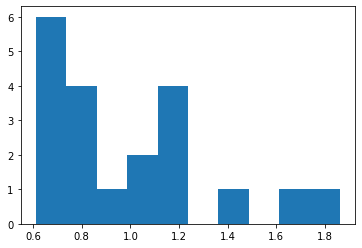

In [ ]:
allPE = []
for m in molecule:
    allPE.append(m.PE)

import matplotlib.pyplot as plt
plt.hist(allPE)
plt.show()

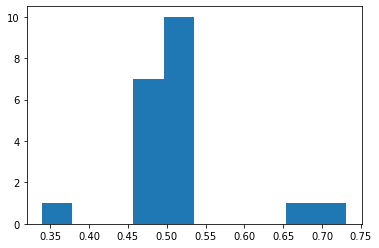

In [ ]:
allAcc = []
for m in molecule:
    allAcc.append(m.acc)

import matplotlib.pyplot as plt
plt.hist(allAcc)
plt.show()

In [ ]:
molecule_pe_before = []
for m in molecule:
    molecule_pe_before.append(m.PE)

molecule_acc_before = []
for m in molecule:
    molecule_acc_before.append(m.acc)


In [ ]:
print(f"\nMinimum PE {best_molecule().PE, best_molecule().acc}")

y = 40
w = float(0.6)
c1 = float(0.1)
c2 = float(0.9)
learning_rate = 0.01
momemtum = 0.5
global_best = best_molecule().weights


Minimum PE (<tf.Tensor: shape=(), dtype=float32, numpy=0.6115412>, 0.7313432835820896)


In [ ]:
loss_history = []
val_loss_history = []
acc_history = []
val_acc_history = []

loss_history_epochs = []
val_loss_history_epochs = []
acc_history_epochs = []
val_acc_history_epochs = []

In [ ]:
num_epochs = 500
e = 0
while(1):
    print(f"Epochs : {e+1}")
    for idx in tqdm(range(len(molecule))):
        # idx = random.randint(0, len(molecule)-1)
        m = molecule[idx]
        # molecule.pop(idx)
        if m.num_hit > y:
            execute_pso_upadte(m, idx)
            logging.info(f"Epochs : {e+1}\tPSO Update ")
        else:
            r = random.random()
            if r > 0.5:
                i = random.randint(0, len(molecule)-1)
                m1 = molecule[i]
                # molecule.pop(i)
                if execute_intermol_ineffective_collision(m, m1, idx, i):
                    logging.info(f"Epochs : {e+1}\tInter Mole ")
                else:
                    logging.info(f"Epochs : {e+1}\tNone ")
                    molecule[idx].num_hit += 1
                    molecule[i].num_hit += 1
                    # molecule.append(m)
                    # molecule.append(m1)
            else:
                if execute_onwall_collision(m, idx):
                    logging.info(f"Epochs : {e+1}\tOn wall ")
                else:
                    logging.info(f"Epochs : {e+1}\tNone ")
                    molecule[idx].num_hit += 1
                    # molecule.append(m)

        global_best_mole = best_molecule()
        global_best = global_best_mole.weights
        loss_history.append(global_best_mole.PE)
        val_loss_history.append(global_best_mole.val_loss)
        acc_history.append(global_best_mole.acc)
        val_acc_history.append(global_best_mole.val_acc)


    print(f"Loss : {global_best_mole.PE}, Val Loss : {global_best_mole.val_loss} Acc : {global_best_mole.acc}, Val Acc : {global_best_mole.val_acc}")
    loss_history_epochs.append(global_best_mole.PE)
    val_loss_history_epochs.append(global_best_mole.val_loss)
    acc_history_epochs.append(global_best_mole.acc)
    val_acc_history_epochs.append(global_best_mole.val_acc)

    e += 1
    if e == num_epochs:
        break

Epochs : 1


100%|██████████| 20/20 [00:07<00:00,  2.80it/s]


Loss : 0.5181357860565186, Val Loss : 0.5139263272285461 Acc : 0.8175033921302578, Val Acc : 0.8291746641074856
Epochs : 2


100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


Loss : 0.3540897071361542, Val Loss : 0.33806371688842773 Acc : 0.8819538670284939, Val Acc : 0.8867562380038387
Epochs : 3


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.30764779448509216, Val Loss : 0.2951536178588867 Acc : 0.8883989145183175, Val Acc : 0.8944337811900192
Epochs : 4


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Loss : 0.29008913040161133, Val Loss : 0.2778288424015045 Acc : 0.8978968792401628, Val Acc : 0.9001919385796545
Epochs : 5


100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


Loss : 0.284669429063797, Val Loss : 0.27474504709243774 Acc : 0.8992537313432836, Val Acc : 0.9040307101727447
Epochs : 6


100%|██████████| 20/20 [00:07<00:00,  2.70it/s]


Loss : 0.2790662944316864, Val Loss : 0.26633208990097046 Acc : 0.9029850746268657, Val Acc : 0.9078694817658349
Epochs : 7


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.2742850184440613, Val Loss : 0.26147302985191345 Acc : 0.9043419267299865, Val Acc : 0.9136276391554703
Epochs : 8


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Loss : 0.25869977474212646, Val Loss : 0.2462591975927353 Acc : 0.9121438263229308, Val Acc : 0.9309021113243762
Epochs : 9


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.2554512917995453, Val Loss : 0.243264839053154 Acc : 0.9128222523744912, Val Acc : 0.9328214971209213
Epochs : 10


100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


Loss : 0.2512681484222412, Val Loss : 0.24681589007377625 Acc : 0.9192672998643148, Val Acc : 0.9309021113243762
Epochs : 11


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.24836038053035736, Val Loss : 0.24348916113376617 Acc : 0.9209633649932157, Val Acc : 0.9309021113243762
Epochs : 12


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.24420781433582306, Val Loss : 0.23224468529224396 Acc : 0.9189280868385346, Val Acc : 0.9424184261036468
Epochs : 13


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.2397538125514984, Val Loss : 0.22455313801765442 Acc : 0.9216417910447762, Val Acc : 0.9404990403071017
Epochs : 14


100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


Loss : 0.23544152081012726, Val Loss : 0.22024470567703247 Acc : 0.9240162822252375, Val Acc : 0.944337811900192
Epochs : 15


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Loss : 0.23298077285289764, Val Loss : 0.2216983139514923 Acc : 0.9236770691994572, Val Acc : 0.944337811900192
Epochs : 16


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


Loss : 0.22734451293945312, Val Loss : 0.21654582023620605 Acc : 0.926729986431479, Val Acc : 0.946257197696737
Epochs : 17


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Loss : 0.22394664585590363, Val Loss : 0.21349689364433289 Acc : 0.9284260515603799, Val Acc : 0.946257197696737
Epochs : 18


100%|██████████| 20/20 [00:07<00:00,  2.80it/s]


Loss : 0.2216256856918335, Val Loss : 0.20706595480442047 Acc : 0.9294436906377205, Val Acc : 0.9481765834932822
Epochs : 19


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.22018857300281525, Val Loss : 0.20575183629989624 Acc : 0.9308005427408412, Val Acc : 0.9481765834932822
Epochs : 20


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Loss : 0.21786648035049438, Val Loss : 0.20815958082675934 Acc : 0.9328358208955224, Val Acc : 0.9481765834932822
Epochs : 21


100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


Loss : 0.2151433378458023, Val Loss : 0.20581687986850739 Acc : 0.9341926729986432, Val Acc : 0.9481765834932822
Epochs : 22


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Loss : 0.21139265596866608, Val Loss : 0.20261956751346588 Acc : 0.9345318860244234, Val Acc : 0.9481765834932822
Epochs : 23


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Loss : 0.21022284030914307, Val Loss : 0.20163002610206604 Acc : 0.9345318860244234, Val Acc : 0.9481765834932822
Epochs : 24


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.21012921631336212, Val Loss : 0.20149017870426178 Acc : 0.9345318860244234, Val Acc : 0.9481765834932822
Epochs : 25


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Loss : 0.20874269306659698, Val Loss : 0.2005435973405838 Acc : 0.9352103120759837, Val Acc : 0.9481765834932822
Epochs : 26


100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


Loss : 0.20779673755168915, Val Loss : 0.1996992975473404 Acc : 0.9352103120759837, Val Acc : 0.9500959692898272
Epochs : 27


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


Loss : 0.2058068811893463, Val Loss : 0.1979750096797943 Acc : 0.9362279511533242, Val Acc : 0.9500959692898272
Epochs : 28


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Loss : 0.20481684803962708, Val Loss : 0.19717705249786377 Acc : 0.9358887381275441, Val Acc : 0.9500959692898272
Epochs : 29


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.20384597778320312, Val Loss : 0.19638517498970032 Acc : 0.9358887381275441, Val Acc : 0.9500959692898272
Epochs : 30


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Loss : 0.2028973251581192, Val Loss : 0.19559505581855774 Acc : 0.9362279511533242, Val Acc : 0.9500959692898272
Epochs : 31


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.2010703682899475, Val Loss : 0.19408710300922394 Acc : 0.9362279511533242, Val Acc : 0.9500959692898272
Epochs : 32


100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


Loss : 0.19933724403381348, Val Loss : 0.19268080592155457 Acc : 0.9365671641791045, Val Acc : 0.9481765834932822
Epochs : 33


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.19850493967533112, Val Loss : 0.19200399518013 Acc : 0.9365671641791045, Val Acc : 0.9481765834932822
Epochs : 34


100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


Loss : 0.19690503180027008, Val Loss : 0.19070802628993988 Acc : 0.9382632293080054, Val Acc : 0.9481765834932822
Epochs : 35


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Loss : 0.19611355662345886, Val Loss : 0.18586911261081696 Acc : 0.9436906377204884, Val Acc : 0.9520153550863724
Epochs : 36


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Loss : 0.19535355269908905, Val Loss : 0.1851797252893448 Acc : 0.9443690637720489, Val Acc : 0.9520153550863724
Epochs : 37


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.19388513267040253, Val Loss : 0.1838538497686386 Acc : 0.944708276797829, Val Acc : 0.9520153550863724
Epochs : 38


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Loss : 0.19248634576797485, Val Loss : 0.18259461224079132 Acc : 0.9453867028493894, Val Acc : 0.9520153550863724
Epochs : 39


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.19181112945079803, Val Loss : 0.18198800086975098 Acc : 0.9460651289009498, Val Acc : 0.9520153550863724
Epochs : 40


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.19115103781223297, Val Loss : 0.1813976913690567 Acc : 0.9460651289009498, Val Acc : 0.9520153550863724
Epochs : 41


100%|██████████| 20/20 [00:06<00:00,  2.86it/s]


Loss : 0.1898745745420456, Val Loss : 0.1802571713924408 Acc : 0.9460651289009498, Val Acc : 0.9520153550863724
Epochs : 42


100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


Loss : 0.18880413472652435, Val Loss : 0.18417668342590332 Acc : 0.9413161465400272, Val Acc : 0.9481765834932822
Epochs : 43


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Loss : 0.18580807745456696, Val Loss : 0.1766408234834671 Acc : 0.94640434192673, Val Acc : 0.9520153550863724
Epochs : 44


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


Loss : 0.18527163565158844, Val Loss : 0.17616772651672363 Acc : 0.9470827679782904, Val Acc : 0.9520153550863724
Epochs : 45


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.18372035026550293, Val Loss : 0.1748088002204895 Acc : 0.9474219810040706, Val Acc : 0.9520153550863724
Epochs : 46


100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


Loss : 0.1822548508644104, Val Loss : 0.17353349924087524 Acc : 0.9474219810040706, Val Acc : 0.9539347408829175
Epochs : 47


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Loss : 0.1817830204963684, Val Loss : 0.17312495410442352 Acc : 0.9474219810040706, Val Acc : 0.9539347408829175
Epochs : 48


100%|██████████| 20/20 [00:05<00:00,  3.89it/s]


Loss : 0.181319460272789, Val Loss : 0.17272314429283142 Acc : 0.9474219810040706, Val Acc : 0.9539347408829175
Epochs : 49


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.18041348457336426, Val Loss : 0.17194165289402008 Acc : 0.9474219810040706, Val Acc : 0.9539347408829175
Epochs : 50


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.18041390180587769, Val Loss : 0.17194202542304993 Acc : 0.9474219810040706, Val Acc : 0.9539347408829175
Epochs : 51


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Loss : 0.180193692445755, Val Loss : 0.1717531979084015 Acc : 0.9474219810040706, Val Acc : 0.9539347408829175
Epochs : 52


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.17948780953884125, Val Loss : 0.17114809155464172 Acc : 0.9477611940298507, Val Acc : 0.9539347408829175
Epochs : 53


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Loss : 0.17868110537528992, Val Loss : 0.17045973241329193 Acc : 0.9477611940298507, Val Acc : 0.9539347408829175
Epochs : 54


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.17786957323551178, Val Loss : 0.16976746916770935 Acc : 0.9481004070556309, Val Acc : 0.9539347408829175
Epochs : 55


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.1774696409702301, Val Loss : 0.1694270819425583 Acc : 0.9481004070556309, Val Acc : 0.9539347408829175
Epochs : 56


100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


Loss : 0.17707586288452148, Val Loss : 0.16909226775169373 Acc : 0.9481004070556309, Val Acc : 0.9539347408829175
Epochs : 57


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Loss : 0.17668752372264862, Val Loss : 0.16876518726348877 Acc : 0.9484396200814111, Val Acc : 0.9539347408829175
Epochs : 58


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Loss : 0.17592597007751465, Val Loss : 0.16812841594219208 Acc : 0.9484396200814111, Val Acc : 0.9539347408829175
Epochs : 59


100%|██████████| 20/20 [00:05<00:00,  3.73it/s]


Loss : 0.17555317282676697, Val Loss : 0.16781780123710632 Acc : 0.9484396200814111, Val Acc : 0.9539347408829175
Epochs : 60


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Loss : 0.17518632113933563, Val Loss : 0.1675109565258026 Acc : 0.9484396200814111, Val Acc : 0.9539347408829175
Epochs : 61


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Loss : 0.17482493817806244, Val Loss : 0.16720741987228394 Acc : 0.9484396200814111, Val Acc : 0.9539347408829175
Epochs : 62


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Loss : 0.17446863651275635, Val Loss : 0.16690731048583984 Acc : 0.9484396200814111, Val Acc : 0.9539347408829175
Epochs : 63


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


Loss : 0.1741168349981308, Val Loss : 0.1666126847267151 Acc : 0.9484396200814111, Val Acc : 0.9539347408829175
Epochs : 64


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.1737692654132843, Val Loss : 0.16632401943206787 Acc : 0.9484396200814111, Val Acc : 0.9539347408829175
Epochs : 65


100%|██████████| 20/20 [00:04<00:00,  4.26it/s]


Loss : 0.17342591285705566, Val Loss : 0.16604062914848328 Acc : 0.9491180461329715, Val Acc : 0.9539347408829175
Epochs : 66


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.17275087535381317, Val Loss : 0.16548827290534973 Acc : 0.9494572591587517, Val Acc : 0.9539347408829175
Epochs : 67


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


Loss : 0.17241936922073364, Val Loss : 0.16521719098091125 Acc : 0.9501356852103121, Val Acc : 0.9539347408829175
Epochs : 68


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Loss : 0.17209157347679138, Val Loss : 0.16494989395141602 Acc : 0.9501356852103121, Val Acc : 0.9539347408829175
Epochs : 69


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.1714480072259903, Val Loss : 0.1644289493560791 Acc : 0.9504748982360922, Val Acc : 0.9539347408829175
Epochs : 70


100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


Loss : 0.17113274335861206, Val Loss : 0.1641741544008255 Acc : 0.9504748982360922, Val Acc : 0.9539347408829175
Epochs : 71


100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


Loss : 0.17021439969539642, Val Loss : 0.16342860460281372 Acc : 0.9508141112618724, Val Acc : 0.9539347408829175
Epochs : 72


100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


Loss : 0.1693343222141266, Val Loss : 0.16272397339344025 Acc : 0.9511533242876526, Val Acc : 0.9539347408829175
Epochs : 73


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Loss : 0.16904856264591217, Val Loss : 0.16249312460422516 Acc : 0.9511533242876526, Val Acc : 0.9539347408829175
Epochs : 74


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Loss : 0.16876636445522308, Val Loss : 0.16226619482040405 Acc : 0.9514925373134329, Val Acc : 0.9539347408829175
Epochs : 75


100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


Loss : 0.16848737001419067, Val Loss : 0.16204366087913513 Acc : 0.9514925373134329, Val Acc : 0.9539347408829175
Epochs : 76


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.16793981194496155, Val Loss : 0.1616079956293106 Acc : 0.9514925373134329, Val Acc : 0.9539347408829175
Epochs : 77


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Loss : 0.16740474104881287, Val Loss : 0.16118314862251282 Acc : 0.9521709633649932, Val Acc : 0.9558541266794626
Epochs : 78


100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


Loss : 0.1671413630247116, Val Loss : 0.16097646951675415 Acc : 0.9521709633649932, Val Acc : 0.9558541266794626
Epochs : 79


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.1668807417154312, Val Loss : 0.16077157855033875 Acc : 0.9521709633649932, Val Acc : 0.9558541266794626
Epochs : 80


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


Loss : 0.16675230860710144, Val Loss : 0.16066932678222656 Acc : 0.9521709633649932, Val Acc : 0.9558541266794626
Epochs : 81


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.16656069457530975, Val Loss : 0.1605173498392105 Acc : 0.9521709633649932, Val Acc : 0.9558541266794626
Epochs : 82


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Loss : 0.16610276699066162, Val Loss : 0.1601586639881134 Acc : 0.9528493894165536, Val Acc : 0.9558541266794626
Epochs : 83


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Loss : 0.16586098074913025, Val Loss : 0.15996938943862915 Acc : 0.9525101763907734, Val Acc : 0.9558541266794626
Epochs : 84


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


Loss : 0.16561771929264069, Val Loss : 0.15977776050567627 Acc : 0.9525101763907734, Val Acc : 0.9558541266794626
Epochs : 85


100%|██████████| 20/20 [00:05<00:00,  3.73it/s]


Loss : 0.16537484526634216, Val Loss : 0.1595878154039383 Acc : 0.9525101763907734, Val Acc : 0.9558541266794626
Epochs : 86


100%|██████████| 20/20 [00:04<00:00,  4.04it/s]


Loss : 0.16513368487358093, Val Loss : 0.15939952433109283 Acc : 0.9525101763907734, Val Acc : 0.9558541266794626
Epochs : 87


100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


Loss : 0.16489505767822266, Val Loss : 0.1592118740081787 Acc : 0.9521709633649932, Val Acc : 0.9558541266794626
Epochs : 88


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


Loss : 0.1646588295698166, Val Loss : 0.15902654826641083 Acc : 0.9521709633649932, Val Acc : 0.9558541266794626
Epochs : 89


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.16442497074604034, Val Loss : 0.15884406864643097 Acc : 0.9521709633649932, Val Acc : 0.9558541266794626
Epochs : 90


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


Loss : 0.16419337689876556, Val Loss : 0.15866433084011078 Acc : 0.9521709633649932, Val Acc : 0.9558541266794626
Epochs : 91


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


Loss : 0.16396410763263702, Val Loss : 0.15848688781261444 Acc : 0.9521709633649932, Val Acc : 0.9558541266794626
Epochs : 92


100%|██████████| 20/20 [00:06<00:00,  2.87it/s]


Loss : 0.16373731195926666, Val Loss : 0.1583096981048584 Acc : 0.9525101763907734, Val Acc : 0.9558541266794626
Epochs : 93


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


Loss : 0.16328944265842438, Val Loss : 0.15795990824699402 Acc : 0.9525101763907734, Val Acc : 0.9558541266794626
Epochs : 94


100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


Loss : 0.16284964978694916, Val Loss : 0.15762053430080414 Acc : 0.9525101763907734, Val Acc : 0.9558541266794626
Epochs : 95


100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


Loss : 0.16263233125209808, Val Loss : 0.15745358169078827 Acc : 0.9525101763907734, Val Acc : 0.9558541266794626
Epochs : 96


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.16241751611232758, Val Loss : 0.15728789567947388 Acc : 0.9525101763907734, Val Acc : 0.9558541266794626
Epochs : 97


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Loss : 0.16220498085021973, Val Loss : 0.15712422132492065 Acc : 0.9525101763907734, Val Acc : 0.9558541266794626
Epochs : 98


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Loss : 0.16199436783790588, Val Loss : 0.15696236491203308 Acc : 0.9525101763907734, Val Acc : 0.9558541266794626
Epochs : 99


100%|██████████| 20/20 [00:09<00:00,  2.12it/s]


Loss : 0.1617855429649353, Val Loss : 0.1568029820919037 Acc : 0.9525101763907734, Val Acc : 0.9558541266794626
Epochs : 100


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Loss : 0.16137324273586273, Val Loss : 0.15648598968982697 Acc : 0.9525101763907734, Val Acc : 0.9558541266794626
Epochs : 101


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Loss : 0.16116967797279358, Val Loss : 0.15632973611354828 Acc : 0.9525101763907734, Val Acc : 0.9558541266794626
Epochs : 102


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Loss : 0.16096793115139008, Val Loss : 0.1561768800020218 Acc : 0.9525101763907734, Val Acc : 0.9558541266794626
Epochs : 103


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Loss : 0.16057071089744568, Val Loss : 0.15587270259857178 Acc : 0.9525101763907734, Val Acc : 0.9558541266794626
Epochs : 104


100%|██████████| 20/20 [00:05<00:00,  3.43it/s]


Loss : 0.16037511825561523, Val Loss : 0.155722513794899 Acc : 0.9528493894165536, Val Acc : 0.9558541266794626
Epochs : 105


100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


Loss : 0.15979906916618347, Val Loss : 0.15527980029582977 Acc : 0.9531886024423338, Val Acc : 0.9558541266794626
Epochs : 106


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.15961027145385742, Val Loss : 0.15513397753238678 Acc : 0.9531886024423338, Val Acc : 0.9558541266794626
Epochs : 107


100%|██████████| 20/20 [00:07<00:00,  2.70it/s]


Loss : 0.15923736989498138, Val Loss : 0.1548435240983963 Acc : 0.9531886024423338, Val Acc : 0.9558541266794626
Epochs : 108


100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


Loss : 0.1590532660484314, Val Loss : 0.15470105409622192 Acc : 0.9531886024423338, Val Acc : 0.9558541266794626
Epochs : 109


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.1586897075176239, Val Loss : 0.1544184684753418 Acc : 0.9535278154681139, Val Acc : 0.9558541266794626
Epochs : 110


100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


Loss : 0.15833193063735962, Val Loss : 0.1541415899991989 Acc : 0.9535278154681139, Val Acc : 0.9558541266794626
Epochs : 111


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Loss : 0.15811210870742798, Val Loss : 0.15396922826766968 Acc : 0.9535278154681139, Val Acc : 0.9558541266794626
Epochs : 112


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Loss : 0.15795931220054626, Val Loss : 0.15385018289089203 Acc : 0.9535278154681139, Val Acc : 0.9558541266794626
Epochs : 113


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Loss : 0.15746092796325684, Val Loss : 0.15346543490886688 Acc : 0.9538670284938942, Val Acc : 0.9558541266794626
Epochs : 114


100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


Loss : 0.1572919487953186, Val Loss : 0.1533355861902237 Acc : 0.9538670284938942, Val Acc : 0.9558541266794626
Epochs : 115


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Loss : 0.15712358057498932, Val Loss : 0.15320493280887604 Acc : 0.9538670284938942, Val Acc : 0.9558541266794626
Epochs : 116


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.15662534534931183, Val Loss : 0.1528175324201584 Acc : 0.9538670284938942, Val Acc : 0.9558541266794626
Epochs : 117


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Loss : 0.15646204352378845, Val Loss : 0.1526925414800644 Acc : 0.9538670284938942, Val Acc : 0.9558541266794626
Epochs : 118


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.1563001275062561, Val Loss : 0.15256772935390472 Acc : 0.9538670284938942, Val Acc : 0.9558541266794626
Epochs : 119


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


Loss : 0.15613941848278046, Val Loss : 0.15244339406490326 Acc : 0.9538670284938942, Val Acc : 0.9558541266794626
Epochs : 120


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


Loss : 0.15597985684871674, Val Loss : 0.15231989324092865 Acc : 0.9542062415196744, Val Acc : 0.9558541266794626
Epochs : 121


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


Loss : 0.15582135319709778, Val Loss : 0.1521986871957779 Acc : 0.9542062415196744, Val Acc : 0.9558541266794626
Epochs : 122


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Loss : 0.15550687909126282, Val Loss : 0.15196242928504944 Acc : 0.9542062415196744, Val Acc : 0.9558541266794626
Epochs : 123


100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


Loss : 0.1553511768579483, Val Loss : 0.1518445611000061 Acc : 0.9542062415196744, Val Acc : 0.9558541266794626
Epochs : 124


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.15504321455955505, Val Loss : 0.15161022543907166 Acc : 0.9542062415196744, Val Acc : 0.9558541266794626
Epochs : 125


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Loss : 0.1545892059803009, Val Loss : 0.1512676477432251 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 126


100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


Loss : 0.1544399857521057, Val Loss : 0.15115465223789215 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 127


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Loss : 0.15429159998893738, Val Loss : 0.15104198455810547 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 128


100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


Loss : 0.15414416790008545, Val Loss : 0.15093077719211578 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 129


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Loss : 0.15399761497974396, Val Loss : 0.15082022547721863 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 130


100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


Loss : 0.15356339514255524, Val Loss : 0.1504926234483719 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 131


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Loss : 0.15327826142311096, Val Loss : 0.15028008818626404 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 132


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.15299655497074127, Val Loss : 0.1500680297613144 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 133


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Loss : 0.15285693109035492, Val Loss : 0.1499619483947754 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 134


100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


Loss : 0.1525803655385971, Val Loss : 0.14975188672542572 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 135


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


Loss : 0.15244363248348236, Val Loss : 0.1496480256319046 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 136


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.1523078829050064, Val Loss : 0.14954395592212677 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 137


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Loss : 0.15217262506484985, Val Loss : 0.14944082498550415 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 138


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Loss : 0.15217262506484985, Val Loss : 0.14944082498550415 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 139


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Loss : 0.15200498700141907, Val Loss : 0.1493120789527893 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 140


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Loss : 0.15188808739185333, Val Loss : 0.14922361075878143 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 141


100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


Loss : 0.15176331996917725, Val Loss : 0.14912840723991394 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 142


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Loss : 0.15150517225265503, Val Loss : 0.14893300831317902 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 143


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


Loss : 0.15137474238872528, Val Loss : 0.1488364189863205 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 144


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Loss : 0.15124459564685822, Val Loss : 0.14873868227005005 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 145


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.15073032677173615, Val Loss : 0.14835450053215027 Acc : 0.9545454545454546, Val Acc : 0.9558541266794626
Epochs : 146


100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


Loss : 0.15047703683376312, Val Loss : 0.14816801249980927 Acc : 0.9548846675712347, Val Acc : 0.9558541266794626
Epochs : 147


100%|██████████| 20/20 [00:07<00:00,  2.86it/s]


Loss : 0.1502261757850647, Val Loss : 0.14797912538051605 Acc : 0.9552238805970149, Val Acc : 0.9577735124760077
Epochs : 148


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.1501016467809677, Val Loss : 0.14788593351840973 Acc : 0.9552238805970149, Val Acc : 0.9577735124760077
Epochs : 149


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Loss : 0.14985421299934387, Val Loss : 0.1477005034685135 Acc : 0.9552238805970149, Val Acc : 0.9577735124760077
Epochs : 150


100%|██████████| 20/20 [00:06<00:00,  2.89it/s]


Loss : 0.14973144233226776, Val Loss : 0.14760839939117432 Acc : 0.9552238805970149, Val Acc : 0.9577735124760077
Epochs : 151


100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


Loss : 0.14948764443397522, Val Loss : 0.14742518961429596 Acc : 0.9555630936227951, Val Acc : 0.9577735124760077
Epochs : 152


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


Loss : 0.1492452323436737, Val Loss : 0.14724203944206238 Acc : 0.9555630936227951, Val Acc : 0.9577735124760077
Epochs : 153


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Loss : 0.14912475645542145, Val Loss : 0.1471499651670456 Acc : 0.9559023066485753, Val Acc : 0.9577735124760077
Epochs : 154


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Loss : 0.14888498187065125, Val Loss : 0.14696890115737915 Acc : 0.9559023066485753, Val Acc : 0.9577735124760077
Epochs : 155


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Loss : 0.14864754676818848, Val Loss : 0.14679096639156342 Acc : 0.9559023066485753, Val Acc : 0.9577735124760077
Epochs : 156


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.14852982759475708, Val Loss : 0.1467016637325287 Acc : 0.9559023066485753, Val Acc : 0.9577735124760077
Epochs : 157


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.14841273427009583, Val Loss : 0.1466149538755417 Acc : 0.9559023066485753, Val Acc : 0.9577735124760077
Epochs : 158


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.14818105101585388, Val Loss : 0.1464410126209259 Acc : 0.9559023066485753, Val Acc : 0.9577735124760077
Epochs : 159


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.14795225858688354, Val Loss : 0.14626720547676086 Acc : 0.9559023066485753, Val Acc : 0.9577735124760077
Epochs : 160


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Loss : 0.14783865213394165, Val Loss : 0.14618270099163055 Acc : 0.9559023066485753, Val Acc : 0.9577735124760077
Epochs : 161


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


Loss : 0.14761309325695038, Val Loss : 0.14601542055606842 Acc : 0.9559023066485753, Val Acc : 0.9577735124760077
Epochs : 162


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.14738911390304565, Val Loss : 0.145846888422966 Acc : 0.9559023066485753, Val Acc : 0.9616122840690979
Epochs : 163


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Loss : 0.14727774262428284, Val Loss : 0.14576439559459686 Acc : 0.9559023066485753, Val Acc : 0.9616122840690979
Epochs : 164


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


Loss : 0.1471397876739502, Val Loss : 0.14566443860530853 Acc : 0.9565807327001357, Val Acc : 0.963531669865643
Epochs : 165


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


Loss : 0.14704349637031555, Val Loss : 0.14559434354305267 Acc : 0.9565807327001357, Val Acc : 0.963531669865643
Epochs : 166


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Loss : 0.1469406932592392, Val Loss : 0.14551779627799988 Acc : 0.9565807327001357, Val Acc : 0.963531669865643
Epochs : 167


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.1468348205089569, Val Loss : 0.1454399675130844 Acc : 0.9565807327001357, Val Acc : 0.963531669865643
Epochs : 168


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.14651274681091309, Val Loss : 0.14520496129989624 Acc : 0.9565807327001357, Val Acc : 0.963531669865643
Epochs : 169


100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


Loss : 0.14629961550235748, Val Loss : 0.14504975080490112 Acc : 0.9565807327001357, Val Acc : 0.963531669865643
Epochs : 170


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.1461937427520752, Val Loss : 0.1449715942144394 Acc : 0.9565807327001357, Val Acc : 0.963531669865643
Epochs : 171


100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


Loss : 0.14608845114707947, Val Loss : 0.14489206671714783 Acc : 0.9565807327001357, Val Acc : 0.963531669865643
Epochs : 172


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Loss : 0.14598390460014343, Val Loss : 0.14481423795223236 Acc : 0.9565807327001357, Val Acc : 0.963531669865643
Epochs : 173


100%|██████████| 20/20 [00:05<00:00,  3.43it/s]


Loss : 0.14588004350662231, Val Loss : 0.14473770558834076 Acc : 0.9565807327001357, Val Acc : 0.963531669865643
Epochs : 174


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.14557048678398132, Val Loss : 0.14450626075267792 Acc : 0.9565807327001357, Val Acc : 0.963531669865643
Epochs : 175


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Loss : 0.14536648988723755, Val Loss : 0.1443561613559723 Acc : 0.9565807327001357, Val Acc : 0.963531669865643
Epochs : 176


100%|██████████| 20/20 [00:05<00:00,  3.43it/s]


Loss : 0.14516420662403107, Val Loss : 0.1442067176103592 Acc : 0.9565807327001357, Val Acc : 0.963531669865643
Epochs : 177


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


Loss : 0.14496475458145142, Val Loss : 0.14405964314937592 Acc : 0.9572591587516961, Val Acc : 0.963531669865643
Epochs : 178


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.14476722478866577, Val Loss : 0.14391161501407623 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 179


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Loss : 0.1444738209247589, Val Loss : 0.14369221031665802 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 180


100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


Loss : 0.14437681436538696, Val Loss : 0.14361999928951263 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 181


100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


Loss : 0.14428015053272247, Val Loss : 0.14354820549488068 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 182


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


Loss : 0.14418382942676544, Val Loss : 0.1434745341539383 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 183


100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


Loss : 0.14399178326129913, Val Loss : 0.14333145320415497 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 184


100%|██████████| 20/20 [00:05<00:00,  3.66it/s]


Loss : 0.14389631152153015, Val Loss : 0.1432599425315857 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 185


100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


Loss : 0.1436123102903366, Val Loss : 0.14304549992084503 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 186


100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


Loss : 0.1435183733701706, Val Loss : 0.14297644793987274 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 187


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.14333178102970123, Val Loss : 0.14283621311187744 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 188


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Loss : 0.1432390958070755, Val Loss : 0.14276334643363953 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 189


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.1432390958070755, Val Loss : 0.14276334643363953 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 190


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Loss : 0.14319300651550293, Val Loss : 0.14272847771644592 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 191


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


Loss : 0.14312399923801422, Val Loss : 0.1426757574081421 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 192


100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


Loss : 0.14304359257221222, Val Loss : 0.14261494576931 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 193


100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


Loss : 0.1429576426744461, Val Loss : 0.14254973828792572 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 194


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.1428692489862442, Val Loss : 0.14248177409172058 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 195


100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


Loss : 0.14268970489501953, Val Loss : 0.14234566688537598 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 196


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Loss : 0.1425098329782486, Val Loss : 0.14220856130123138 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 197


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Loss : 0.14233121275901794, Val Loss : 0.14207331836223602 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 198


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Loss : 0.14224229753017426, Val Loss : 0.14200443029403687 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 199


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


Loss : 0.14206542074680328, Val Loss : 0.14186979830265045 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 200


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.14197741448879242, Val Loss : 0.14180147647857666 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 201


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.1418897658586502, Val Loss : 0.14173442125320435 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 202


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Loss : 0.14180251955986023, Val Loss : 0.14166903495788574 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 203


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Loss : 0.1417156159877777, Val Loss : 0.14160394668579102 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 204


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.1415427178144455, Val Loss : 0.141472727060318 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 205


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.14145678281784058, Val Loss : 0.1414063274860382 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 206


100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


Loss : 0.1413709968328476, Val Loss : 0.14134028553962708 Acc : 0.9575983717774763, Val Acc : 0.963531669865643
Epochs : 207


100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


Loss : 0.14127865433692932, Val Loss : 0.14785490930080414 Acc : 0.9586160108548168, Val Acc : 0.963531669865643
Epochs : 208


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.1410938799381256, Val Loss : 0.14771586656570435 Acc : 0.9586160108548168, Val Acc : 0.963531669865643
Epochs : 209


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.14091049134731293, Val Loss : 0.1475796401500702 Acc : 0.9586160108548168, Val Acc : 0.963531669865643
Epochs : 210


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Loss : 0.1408192217350006, Val Loss : 0.14751236140727997 Acc : 0.9586160108548168, Val Acc : 0.963531669865643
Epochs : 211


100%|██████████| 20/20 [00:05<00:00,  3.98it/s]


Loss : 0.14072832465171814, Val Loss : 0.14744356274604797 Acc : 0.9586160108548168, Val Acc : 0.963531669865643
Epochs : 212


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


Loss : 0.14054732024669647, Val Loss : 0.14730840921401978 Acc : 0.9586160108548168, Val Acc : 0.963531669865643
Epochs : 213


100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


Loss : 0.1404573768377304, Val Loss : 0.14724254608154297 Acc : 0.9586160108548168, Val Acc : 0.963531669865643
Epochs : 214


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.1402786821126938, Val Loss : 0.14710840582847595 Acc : 0.9586160108548168, Val Acc : 0.963531669865643
Epochs : 215


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Loss : 0.14018972218036652, Val Loss : 0.14704303443431854 Acc : 0.9586160108548168, Val Acc : 0.963531669865643
Epochs : 216


100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


Loss : 0.14010128378868103, Val Loss : 0.14697766304016113 Acc : 0.9586160108548168, Val Acc : 0.963531669865643
Epochs : 217


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Loss : 0.14001330733299255, Val Loss : 0.14691239595413208 Acc : 0.9586160108548168, Val Acc : 0.963531669865643
Epochs : 218


100%|██████████| 20/20 [00:05<00:00,  3.33it/s]


Loss : 0.1398383378982544, Val Loss : 0.1467818319797516 Acc : 0.9586160108548168, Val Acc : 0.963531669865643
Epochs : 219


100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


Loss : 0.13975143432617188, Val Loss : 0.14671841263771057 Acc : 0.9586160108548168, Val Acc : 0.963531669865643
Epochs : 220


100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


Loss : 0.13975149393081665, Val Loss : 0.14671848714351654 Acc : 0.9586160108548168, Val Acc : 0.963531669865643
Epochs : 221


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.1397082507610321, Val Loss : 0.1466866284608841 Acc : 0.9586160108548168, Val Acc : 0.963531669865643
Epochs : 222


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


Loss : 0.13961687684059143, Val Loss : 0.14001376926898956 Acc : 0.9579375848032564, Val Acc : 0.963531669865643
Epochs : 223


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


Loss : 0.13954207301139832, Val Loss : 0.1399565041065216 Acc : 0.9579375848032564, Val Acc : 0.963531669865643
Epochs : 224


100%|██████████| 20/20 [00:05<00:00,  3.90it/s]


Loss : 0.1394047886133194, Val Loss : 0.14646315574645996 Acc : 0.9586160108548168, Val Acc : 0.963531669865643
Epochs : 225


100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


Loss : 0.13932062685489655, Val Loss : 0.14640142023563385 Acc : 0.9586160108548168, Val Acc : 0.963531669865643
Epochs : 226


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.139229878783226, Val Loss : 0.13971538841724396 Acc : 0.9579375848032564, Val Acc : 0.963531669865643
Epochs : 227


100%|██████████| 20/20 [00:05<00:00,  3.33it/s]


Loss : 0.1390666961669922, Val Loss : 0.1462162584066391 Acc : 0.9586160108548168, Val Acc : 0.963531669865643
Epochs : 228


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.13889829814434052, Val Loss : 0.1460924595594406 Acc : 0.9589552238805971, Val Acc : 0.963531669865643
Epochs : 229


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Loss : 0.13864775002002716, Val Loss : 0.14591066539287567 Acc : 0.9589552238805971, Val Acc : 0.963531669865643
Epochs : 230


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Loss : 0.13856467604637146, Val Loss : 0.14584898948669434 Acc : 0.9589552238805971, Val Acc : 0.963531669865643
Epochs : 231


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Loss : 0.13848184049129486, Val Loss : 0.14578916132450104 Acc : 0.9589552238805971, Val Acc : 0.963531669865643
Epochs : 232


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Loss : 0.1383991688489914, Val Loss : 0.14572803676128387 Acc : 0.9592944369063772, Val Acc : 0.963531669865643
Epochs : 233


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Loss : 0.13831661641597748, Val Loss : 0.14566795527935028 Acc : 0.9592944369063772, Val Acc : 0.963531669865643
Epochs : 234


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.13815224170684814, Val Loss : 0.1455482840538025 Acc : 0.9592944369063772, Val Acc : 0.963531669865643
Epochs : 235


100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


Loss : 0.13807040452957153, Val Loss : 0.14548999071121216 Acc : 0.9592944369063772, Val Acc : 0.963531669865643
Epochs : 236


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.13798880577087402, Val Loss : 0.14543069899082184 Acc : 0.9592944369063772, Val Acc : 0.963531669865643
Epochs : 237


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


Loss : 0.13774530589580536, Val Loss : 0.14525744318962097 Acc : 0.9592944369063772, Val Acc : 0.963531669865643
Epochs : 238


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Loss : 0.1375843733549118, Val Loss : 0.1451423168182373 Acc : 0.9592944369063772, Val Acc : 0.963531669865643
Epochs : 239


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Loss : 0.13742437958717346, Val Loss : 0.14502927660942078 Acc : 0.9592944369063772, Val Acc : 0.963531669865643
Epochs : 240


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Loss : 0.13734473288059235, Val Loss : 0.1449729949235916 Acc : 0.9592944369063772, Val Acc : 0.963531669865643
Epochs : 241


100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


Loss : 0.13726544380187988, Val Loss : 0.14491739869117737 Acc : 0.9592944369063772, Val Acc : 0.963531669865643
Epochs : 242


100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


Loss : 0.1371077299118042, Val Loss : 0.1448068469762802 Acc : 0.9592944369063772, Val Acc : 0.963531669865643
Epochs : 243


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


Loss : 0.13702929019927979, Val Loss : 0.14475302398204803 Acc : 0.9592944369063772, Val Acc : 0.963531669865643
Epochs : 244


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


Loss : 0.13695116341114044, Val Loss : 0.1446993201971054 Acc : 0.9596336499321574, Val Acc : 0.9654510556621881
Epochs : 245


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.13687336444854736, Val Loss : 0.1446431428194046 Acc : 0.9596336499321574, Val Acc : 0.9654510556621881
Epochs : 246


100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


Loss : 0.13671866059303284, Val Loss : 0.1445348858833313 Acc : 0.9596336499321574, Val Acc : 0.9654510556621881
Epochs : 247


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Loss : 0.1364884227514267, Val Loss : 0.14437247812747955 Acc : 0.9596336499321574, Val Acc : 0.9654510556621881
Epochs : 248


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.1364884227514267, Val Loss : 0.14437247812747955 Acc : 0.9596336499321574, Val Acc : 0.9654510556621881
Epochs : 249


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


Loss : 0.13645024597644806, Val Loss : 0.14434632658958435 Acc : 0.9596336499321574, Val Acc : 0.9654510556621881
Epochs : 250


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Loss : 0.13639311492443085, Val Loss : 0.14430591464042664 Acc : 0.9596336499321574, Val Acc : 0.9654510556621881
Epochs : 251


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


Loss : 0.1362554132938385, Val Loss : 0.14420728385448456 Acc : 0.9596336499321574, Val Acc : 0.9654510556621881
Epochs : 252


100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


Loss : 0.13618206977844238, Val Loss : 0.14415600895881653 Acc : 0.9596336499321574, Val Acc : 0.9654510556621881
Epochs : 253


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Loss : 0.13603319227695465, Val Loss : 0.14405030012130737 Acc : 0.9596336499321574, Val Acc : 0.9654510556621881
Epochs : 254


100%|██████████| 20/20 [00:04<00:00,  4.02it/s]


Loss : 0.13595853745937347, Val Loss : 0.14399661123752594 Acc : 0.9596336499321574, Val Acc : 0.9654510556621881
Epochs : 255


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.13580957055091858, Val Loss : 0.14389261603355408 Acc : 0.9596336499321574, Val Acc : 0.9654510556621881
Epochs : 256


100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


Loss : 0.13573528826236725, Val Loss : 0.1438402235507965 Acc : 0.9596336499321574, Val Acc : 0.9654510556621881
Epochs : 257


100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


Loss : 0.13551363348960876, Val Loss : 0.14368100464344025 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 258


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Loss : 0.13544026017189026, Val Loss : 0.14362922310829163 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 259


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


Loss : 0.13536715507507324, Val Loss : 0.14357756078243256 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 260


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Loss : 0.13529425859451294, Val Loss : 0.14352665841579437 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 261


100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


Loss : 0.1352214366197586, Val Loss : 0.14347553253173828 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 262


100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


Loss : 0.13514861464500427, Val Loss : 0.14342422783374786 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 263


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Loss : 0.13507594168186188, Val Loss : 0.1433737576007843 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 264


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.13500340282917023, Val Loss : 0.14332349598407745 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 265


100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


Loss : 0.1349310278892517, Val Loss : 0.1432715803384781 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 266


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Loss : 0.13478678464889526, Val Loss : 0.1431700438261032 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 267


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.13464370369911194, Val Loss : 0.14307072758674622 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 268


100%|██████████| 20/20 [00:05<00:00,  3.66it/s]


Loss : 0.13457240164279938, Val Loss : 0.14302124083042145 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 269


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Loss : 0.13443045318126678, Val Loss : 0.14292316138744354 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 270


100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


Loss : 0.13435974717140198, Val Loss : 0.1428733766078949 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 271


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Loss : 0.13428927958011627, Val Loss : 0.14282433688640594 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 272


100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


Loss : 0.13421913981437683, Val Loss : 0.14277619123458862 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 273


100%|██████████| 20/20 [00:05<00:00,  3.60it/s]


Loss : 0.1341492235660553, Val Loss : 0.14272958040237427 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 274


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.13400988280773163, Val Loss : 0.14263327419757843 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 275


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


Loss : 0.13394057750701904, Val Loss : 0.14258533716201782 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 276


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Loss : 0.13387154042720795, Val Loss : 0.1425374299287796 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 277


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.13380277156829834, Val Loss : 0.14249137043952942 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 278


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Loss : 0.13366596400737762, Val Loss : 0.14239969849586487 Acc : 0.9599728629579376, Val Acc : 0.9654510556621881
Epochs : 279


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


Loss : 0.1335979402065277, Val Loss : 0.14235256612300873 Acc : 0.9599728629579376, Val Acc : 0.9654510556621881
Epochs : 280


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


Loss : 0.1335979402065277, Val Loss : 0.14235256612300873 Acc : 0.9599728629579376, Val Acc : 0.9654510556621881
Epochs : 281


100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


Loss : 0.13351331651210785, Val Loss : 0.14229626953601837 Acc : 0.9599728629579376, Val Acc : 0.9654510556621881
Epochs : 282


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Loss : 0.13345420360565186, Val Loss : 0.14225417375564575 Acc : 0.9599728629579376, Val Acc : 0.9654510556621881
Epochs : 283


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Loss : 0.13325990736484528, Val Loss : 0.14212407171726227 Acc : 0.9599728629579376, Val Acc : 0.9654510556621881
Epochs : 284


100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


Loss : 0.1331935077905655, Val Loss : 0.14207735657691956 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 285


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.13306055963039398, Val Loss : 0.14198832213878632 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 286


100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


Loss : 0.1329277753829956, Val Loss : 0.14189794659614563 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 287


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.13279570639133453, Val Loss : 0.14180988073349 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 288


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.13272994756698608, Val Loss : 0.141764298081398 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 289


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.13259868323802948, Val Loss : 0.1416725516319275 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 290


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Loss : 0.132402703166008, Val Loss : 0.1415398269891739 Acc : 0.9603120759837178, Val Acc : 0.9654510556621881
Epochs : 291


100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


Loss : 0.1322076916694641, Val Loss : 0.14140619337558746 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 292


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Loss : 0.132013738155365, Val Loss : 0.141275554895401 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 293


100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


Loss : 0.13188493251800537, Val Loss : 0.14118918776512146 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 294


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.13182063400745392, Val Loss : 0.1411454826593399 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 295


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Loss : 0.13169215619564056, Val Loss : 0.1410599797964096 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 296


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.13162805140018463, Val Loss : 0.14101634919643402 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 297


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.13150031864643097, Val Loss : 0.1409319043159485 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 298


100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


Loss : 0.13143661618232727, Val Loss : 0.14088808000087738 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 299


100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


Loss : 0.13137312233448029, Val Loss : 0.14084529876708984 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 300


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Loss : 0.13130971789360046, Val Loss : 0.1408039778470993 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 301


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Loss : 0.13118335604667664, Val Loss : 0.14071901142597198 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 302


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


Loss : 0.13112035393714905, Val Loss : 0.14067372679710388 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 303


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


Loss : 0.13105741143226624, Val Loss : 0.1406296342611313 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 304


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.13093166053295135, Val Loss : 0.14054462313652039 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 305


100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


Loss : 0.13083752989768982, Val Loss : 0.14047886431217194 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 306


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


Loss : 0.13073579967021942, Val Loss : 0.14040827751159668 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 307


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Loss : 0.13061679899692535, Val Loss : 0.14032454788684845 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 308


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.13043175637722015, Val Loss : 0.14019641280174255 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 309


100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


Loss : 0.13036999106407166, Val Loss : 0.14015361666679382 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 310


100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


Loss : 0.1302468180656433, Val Loss : 0.14007003605365753 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 311


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Loss : 0.13006266951560974, Val Loss : 0.1399400681257248 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 312


100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


Loss : 0.1299402415752411, Val Loss : 0.1398579478263855 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 313


100%|██████████| 20/20 [00:06<00:00,  2.91it/s]


Loss : 0.12981824576854706, Val Loss : 0.1397717446088791 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 314


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Loss : 0.12969674170017242, Val Loss : 0.13968878984451294 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 315


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Loss : 0.12957565486431122, Val Loss : 0.13960407674312592 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 316


100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


Loss : 0.12951529026031494, Val Loss : 0.13956232368946075 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 317


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Loss : 0.129455104470253, Val Loss : 0.13952098786830902 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 318


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.1293950378894806, Val Loss : 0.13947898149490356 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 319


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Loss : 0.12933498620986938, Val Loss : 0.1394374817609787 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 320


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


Loss : 0.12927503883838654, Val Loss : 0.13939620554447174 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 321


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.12921521067619324, Val Loss : 0.1393546313047409 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 322


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Loss : 0.12915559113025665, Val Loss : 0.13931269943714142 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 323


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Loss : 0.129036545753479, Val Loss : 0.13923081755638123 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 324


100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


Loss : 0.12891775369644165, Val Loss : 0.13914690911769867 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 325


100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


Loss : 0.1287403106689453, Val Loss : 0.13902604579925537 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 326


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.12868142127990723, Val Loss : 0.13898563385009766 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 327


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Loss : 0.12850525975227356, Val Loss : 0.1388644427061081 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 328


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.1284472644329071, Val Loss : 0.13882726430892944 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 329


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Loss : 0.12841850519180298, Val Loss : 0.13880717754364014 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 330


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Loss : 0.12837539613246918, Val Loss : 0.13877877593040466 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 331


100%|██████████| 20/20 [00:04<00:00,  4.03it/s]


Loss : 0.1283251792192459, Val Loss : 0.1387447863817215 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 332


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Loss : 0.12821583449840546, Val Loss : 0.13867205381393433 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 333


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Loss : 0.12815943360328674, Val Loss : 0.13863274455070496 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 334


100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


Loss : 0.12798869609832764, Val Loss : 0.13851946592330933 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 335


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Loss : 0.12793175876140594, Val Loss : 0.13848040997982025 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 336


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.12776148319244385, Val Loss : 0.13836383819580078 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 337


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Loss : 0.12759223580360413, Val Loss : 0.13824918866157532 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 338


100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


Loss : 0.1274239420890808, Val Loss : 0.1381348818540573 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 339


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Loss : 0.1273680180311203, Val Loss : 0.13809886574745178 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 340


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.12731216847896576, Val Loss : 0.1380622386932373 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 341


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


Loss : 0.12725643813610077, Val Loss : 0.13802506029605865 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 342


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.12720075249671936, Val Loss : 0.1379873901605606 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 343


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.12714508175849915, Val Loss : 0.1379493623971939 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 344


100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


Loss : 0.12708966434001923, Val Loss : 0.1379106342792511 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 345


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Loss : 0.12703435122966766, Val Loss : 0.13787387311458588 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 346


100%|██████████| 20/20 [00:05<00:00,  3.43it/s]


Loss : 0.12697918713092804, Val Loss : 0.1378367841243744 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 347


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Loss : 0.12692415714263916, Val Loss : 0.13780029118061066 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 348


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Loss : 0.12686915695667267, Val Loss : 0.13776114583015442 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 349


100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


Loss : 0.1268143355846405, Val Loss : 0.1377238631248474 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 350


100%|██████████| 20/20 [00:07<00:00,  2.69it/s]


Loss : 0.12675964832305908, Val Loss : 0.13768748939037323 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 351


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Loss : 0.1267050951719284, Val Loss : 0.1376495659351349 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 352


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.12659625709056854, Val Loss : 0.13757731020450592 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 353


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.12648791074752808, Val Loss : 0.1375015377998352 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 354


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.12638016045093536, Val Loss : 0.13742758333683014 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 355


100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


Loss : 0.1263265609741211, Val Loss : 0.1373913586139679 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 356


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


Loss : 0.12621991336345673, Val Loss : 0.13732139766216278 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 357


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


Loss : 0.12615348398685455, Val Loss : 0.13727524876594543 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 358


100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


Loss : 0.1261070966720581, Val Loss : 0.13724398612976074 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 359


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Loss : 0.1260574460029602, Val Loss : 0.13721150159835815 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 360


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


Loss : 0.12600615620613098, Val Loss : 0.13717864453792572 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 361


100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


Loss : 0.12595409154891968, Val Loss : 0.13714420795440674 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 362


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.12590163946151733, Val Loss : 0.1371081918478012 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 363


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Loss : 0.12579627335071564, Val Loss : 0.13704022765159607 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 364


100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


Loss : 0.12574359774589539, Val Loss : 0.13700328767299652 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 365


100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


Loss : 0.12569095194339752, Val Loss : 0.13696815073490143 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 366


100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


Loss : 0.12563838064670563, Val Loss : 0.13693177700042725 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 367


100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


Loss : 0.12553350627422333, Val Loss : 0.13686271011829376 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 368


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.12542885541915894, Val Loss : 0.13678909838199615 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 369


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Loss : 0.1253766417503357, Val Loss : 0.1367540955543518 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 370


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Loss : 0.125324547290802, Val Loss : 0.13671892881393433 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 371


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Loss : 0.1252727210521698, Val Loss : 0.1366817206144333 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 372


100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


Loss : 0.12516935169696808, Val Loss : 0.13661104440689087 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 373


100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


Loss : 0.1251177340745926, Val Loss : 0.1365765482187271 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 374


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.12501445412635803, Val Loss : 0.13650797307491302 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 375


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.12485974282026291, Val Loss : 0.13640472292900085 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 376


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.12480837851762772, Val Loss : 0.13637089729309082 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 377


100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


Loss : 0.12475703656673431, Val Loss : 0.13633860647678375 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 378


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Loss : 0.12470567971467972, Val Loss : 0.13630560040473938 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 379


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


Loss : 0.12465433031320572, Val Loss : 0.1362711787223816 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 380


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Loss : 0.12460319697856903, Val Loss : 0.13623873889446259 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 381


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Loss : 0.12455207854509354, Val Loss : 0.13620664179325104 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 382


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.12450122088193893, Val Loss : 0.1361730992794037 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 383


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Loss : 0.12439966946840286, Val Loss : 0.1361040323972702 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 384


100%|██████████| 20/20 [00:06<00:00,  2.87it/s]


Loss : 0.12434927374124527, Val Loss : 0.13607211410999298 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 385


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Loss : 0.12429910153150558, Val Loss : 0.13604006171226501 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 386


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Loss : 0.12419931590557098, Val Loss : 0.13597333431243896 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 387


100%|██████████| 20/20 [00:05<00:00,  3.82it/s]


Loss : 0.1240999773144722, Val Loss : 0.13590747117996216 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 388


100%|██████████| 20/20 [00:05<00:00,  3.99it/s]


Loss : 0.12405044585466385, Val Loss : 0.1358753740787506 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 389


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


Loss : 0.12402577698230743, Val Loss : 0.13585959374904633 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 390


100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


Loss : 0.12398885935544968, Val Loss : 0.13583365082740784 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 391


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Loss : 0.1238037720322609, Val Loss : 0.13571083545684814 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 392


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.1237550750374794, Val Loss : 0.13567954301834106 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 393


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.12370633333921432, Val Loss : 0.1356489509344101 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 394


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Loss : 0.12365749478340149, Val Loss : 0.13561774790287018 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 395


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.12360871583223343, Val Loss : 0.13558395206928253 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 396


100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


Loss : 0.1235111728310585, Val Loss : 0.13551738858222961 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 397


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Loss : 0.1234624832868576, Val Loss : 0.13548824191093445 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 398


100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


Loss : 0.12341378629207611, Val Loss : 0.13545724749565125 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 399


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


Loss : 0.12336520105600357, Val Loss : 0.13542313873767853 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 400


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Loss : 0.12331666797399521, Val Loss : 0.13539013266563416 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 401


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


Loss : 0.12326820194721222, Val Loss : 0.1353600174188614 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 402


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


Loss : 0.12321984767913818, Val Loss : 0.1353301703929901 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 403


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.12317152321338654, Val Loss : 0.13529668748378754 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 404


100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


Loss : 0.12312330305576324, Val Loss : 0.13526389002799988 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 405


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.12302710115909576, Val Loss : 0.13520115613937378 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 406


100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


Loss : 0.12297911942005157, Val Loss : 0.1351701319217682 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 407


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.12288329005241394, Val Loss : 0.13510353863239288 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 408


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Loss : 0.1227400153875351, Val Loss : 0.13501057028770447 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 409


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.12269236147403717, Val Loss : 0.13497987389564514 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 410


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


Loss : 0.12259722501039505, Val Loss : 0.13491734862327576 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 411


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.12254972010850906, Val Loss : 0.13488593697547913 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 412


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.12250220775604248, Val Loss : 0.1348552703857422 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 413


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.12245473265647888, Val Loss : 0.13482211530208588 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 414


100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


Loss : 0.12240735441446304, Val Loss : 0.13479134440422058 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 415


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Loss : 0.1223599910736084, Val Loss : 0.1347614824771881 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 416


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.12231266498565674, Val Loss : 0.13472981750965118 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 417


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Loss : 0.12221813946962357, Val Loss : 0.13466830551624298 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 418


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.12210048735141754, Val Loss : 0.1345912516117096 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 419


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.12206533551216125, Val Loss : 0.13456889986991882 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 420


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Loss : 0.12202437967061996, Val Loss : 0.1345425248146057 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 421


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.12198056280612946, Val Loss : 0.13451506197452545 Acc : 0.9606512890094979, Val Acc : 0.9654510556621881
Epochs : 422


100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


Loss : 0.12193529307842255, Val Loss : 0.13448446989059448 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 423


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.12188930809497833, Val Loss : 0.13445310294628143 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 424


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


Loss : 0.12184296548366547, Val Loss : 0.13442431390285492 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 425


100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


Loss : 0.12179642915725708, Val Loss : 0.13439501821994781 Acc : 0.9609905020352781, Val Acc : 0.9654510556621881
Epochs : 426


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Loss : 0.12174981832504272, Val Loss : 0.13436485826969147 Acc : 0.9613297150610584, Val Acc : 0.9654510556621881
Epochs : 427


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.12170322239398956, Val Loss : 0.13433274626731873 Acc : 0.9613297150610584, Val Acc : 0.9654510556621881
Epochs : 428


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Loss : 0.12161006778478622, Val Loss : 0.1342734396457672 Acc : 0.9616689280868386, Val Acc : 0.9654510556621881
Epochs : 429


100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


Loss : 0.12151703238487244, Val Loss : 0.13421151041984558 Acc : 0.9616689280868386, Val Acc : 0.9654510556621881
Epochs : 430


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.12142439186573029, Val Loss : 0.1341525763273239 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 431


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.1213320642709732, Val Loss : 0.13409309089183807 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 432


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Loss : 0.12128593772649765, Val Loss : 0.13406211137771606 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 433


100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


Loss : 0.1212397962808609, Val Loss : 0.13403214514255524 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 434


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Loss : 0.12119366973638535, Val Loss : 0.13400419056415558 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 435


100%|██████████| 20/20 [00:07<00:00,  2.85it/s]


Loss : 0.12110153585672379, Val Loss : 0.13394378125667572 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 436


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Loss : 0.12105559557676315, Val Loss : 0.1339145451784134 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 437


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


Loss : 0.12100972980260849, Val Loss : 0.13388504087924957 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 438


100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


Loss : 0.12096397578716278, Val Loss : 0.1338542252779007 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 439


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Loss : 0.1208728477358818, Val Loss : 0.13379709422588348 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 440


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.12078192085027695, Val Loss : 0.13373689353466034 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 441


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Loss : 0.12073660641908646, Val Loss : 0.13370706140995026 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 442


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


Loss : 0.12064630538225174, Val Loss : 0.13364817202091217 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 443


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.12055625766515732, Val Loss : 0.13359254598617554 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 444


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


Loss : 0.12046656757593155, Val Loss : 0.13352860510349274 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 445


100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


Loss : 0.12037722021341324, Val Loss : 0.1334747076034546 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 446


100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


Loss : 0.12028831243515015, Val Loss : 0.1334141492843628 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 447


100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


Loss : 0.12023300677537918, Val Loss : 0.1333792358636856 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 448


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.1201944425702095, Val Loss : 0.13335421681404114 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 449


100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


Loss : 0.12015322595834732, Val Loss : 0.13332810997962952 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 450


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.1200677677989006, Val Loss : 0.13327261805534363 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 451


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Loss : 0.12002460658550262, Val Loss : 0.13324207067489624 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 452


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Loss : 0.11998134851455688, Val Loss : 0.1332157999277115 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 453


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Loss : 0.11993806064128876, Val Loss : 0.1331908106803894 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 454


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Loss : 0.11989479511976242, Val Loss : 0.13316048681735992 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 455


100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


Loss : 0.11985153704881668, Val Loss : 0.13312996923923492 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 456


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.11980829387903214, Val Loss : 0.13310366868972778 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 457


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Loss : 0.11972211301326752, Val Loss : 0.13305014371871948 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 458


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.11967914551496506, Val Loss : 0.13301946222782135 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 459


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Loss : 0.119636170566082, Val Loss : 0.13299374282360077 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 460


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Loss : 0.11959321051836014, Val Loss : 0.13296596705913544 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 461


100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


Loss : 0.11955029517412186, Val Loss : 0.13293765485286713 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 462


100%|██████████| 20/20 [00:06<00:00,  2.87it/s]


Loss : 0.11946459859609604, Val Loss : 0.13288351893424988 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 463


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.1193791851401329, Val Loss : 0.1328279823064804 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 464


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Loss : 0.11929403990507126, Val Loss : 0.1327723264694214 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 465


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Loss : 0.1192515641450882, Val Loss : 0.13274650275707245 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 466


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.1192091554403305, Val Loss : 0.1327185481786728 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 467


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Loss : 0.11912447959184647, Val Loss : 0.13266392052173615 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 468


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Loss : 0.11908219754695892, Val Loss : 0.1326359063386917 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 469


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Loss : 0.11904001235961914, Val Loss : 0.13260827958583832 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 470


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


Loss : 0.11899781227111816, Val Loss : 0.13258139789104462 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 471


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.11895579844713211, Val Loss : 0.1325543224811554 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 472


100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


Loss : 0.11887194216251373, Val Loss : 0.13249969482421875 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 473


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Loss : 0.11883008480072021, Val Loss : 0.13247016072273254 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 474


100%|██████████| 20/20 [00:07<00:00,  2.82it/s]


Loss : 0.11878828704357147, Val Loss : 0.13244162499904633 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 475


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Loss : 0.11874647438526154, Val Loss : 0.13241666555404663 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 476


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.11870470643043518, Val Loss : 0.13238848745822906 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 477


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


Loss : 0.11866297572851181, Val Loss : 0.13235969841480255 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 478


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Loss : 0.118621326982975, Val Loss : 0.1323317587375641 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 479


100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


Loss : 0.1185796707868576, Val Loss : 0.13230371475219727 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 480


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Loss : 0.118558868765831, Val Loss : 0.1322917491197586 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 481


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


Loss : 0.11852766573429108, Val Loss : 0.1322704702615738 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 482


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


Loss : 0.11849123984575272, Val Loss : 0.13224419951438904 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 483


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Loss : 0.11845222860574722, Val Loss : 0.1322188824415207 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 484


100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


Loss : 0.11841195076704025, Val Loss : 0.1321910321712494 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 485


100%|██████████| 20/20 [00:05<00:00,  4.00it/s]


Loss : 0.11837103217840195, Val Loss : 0.13216237723827362 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 486


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.11824707686901093, Val Loss : 0.1320791244506836 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 487


100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


Loss : 0.1182057112455368, Val Loss : 0.13205033540725708 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 488


100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


Loss : 0.11816440522670746, Val Loss : 0.13202017545700073 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 489


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Loss : 0.11804074794054031, Val Loss : 0.13193684816360474 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 490


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Loss : 0.11791760474443436, Val Loss : 0.13185091316699982 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 491


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Loss : 0.11783584207296371, Val Loss : 0.13179373741149902 Acc : 0.9620081411126187, Val Acc : 0.9654510556621881
Epochs : 492


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.11775434017181396, Val Loss : 0.13174355030059814 Acc : 0.9623473541383989, Val Acc : 0.9654510556621881
Epochs : 493


100%|██████████| 20/20 [00:07<00:00,  2.72it/s]


Loss : 0.11771363765001297, Val Loss : 0.13171255588531494 Acc : 0.9623473541383989, Val Acc : 0.9654510556621881
Epochs : 494


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.11759181320667267, Val Loss : 0.1316300481557846 Acc : 0.9623473541383989, Val Acc : 0.9654510556621881
Epochs : 495


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Loss : 0.11755131185054779, Val Loss : 0.13160395622253418 Acc : 0.9623473541383989, Val Acc : 0.9654510556621881
Epochs : 496


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.1174703910946846, Val Loss : 0.13154630362987518 Acc : 0.9623473541383989, Val Acc : 0.9654510556621881
Epochs : 497


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.11743000149726868, Val Loss : 0.1315188705921173 Acc : 0.9623473541383989, Val Acc : 0.9654510556621881
Epochs : 498


100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


Loss : 0.11734944581985474, Val Loss : 0.1314648538827896 Acc : 0.9623473541383989, Val Acc : 0.9654510556621881
Epochs : 499


100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


Loss : 0.11726916581392288, Val Loss : 0.13140933215618134 Acc : 0.9623473541383989, Val Acc : 0.9654510556621881
Epochs : 500


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]

Loss : 0.11718922853469849, Val Loss : 0.13135795295238495 Acc : 0.9623473541383989, Val Acc : 0.9654510556621881


- Loss : 0.3686802387237549,
- Val Loss : 0.40306156873703003
- Acc : 0.8287721872329712,
- Val Acc : 0.8287723660469055

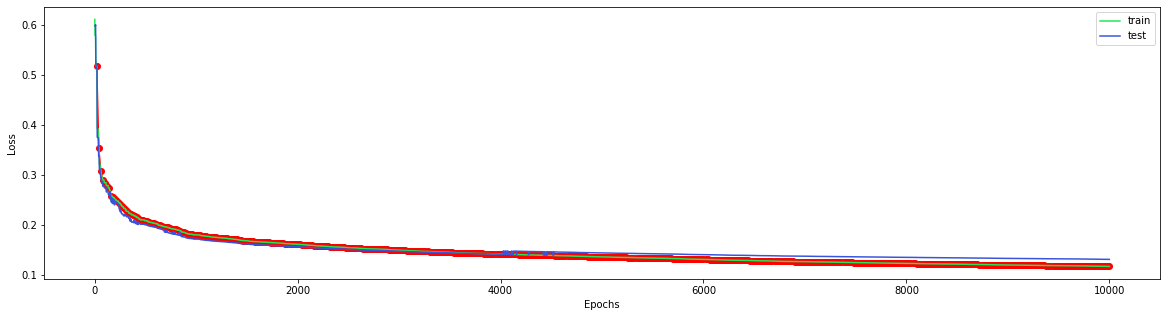

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
x = [i for i in range(1, len(loss_history)+1)]
x1 = [20*i for i in range(1, len(loss_history_epochs)+1)]
fig = plt.figure(figsize=(20,5))

plt.plot(x1, loss_history_epochs, color = '#ff0000', marker='o')
plt.plot(x, loss_history, label = "train", color= '#20e658')
plt.plot(x, val_loss_history, label = 'test', color = '#3954db')


# plt.ylim(ymin=0.4,ymax=1.35)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig(BASE_PATH+"loss.png")

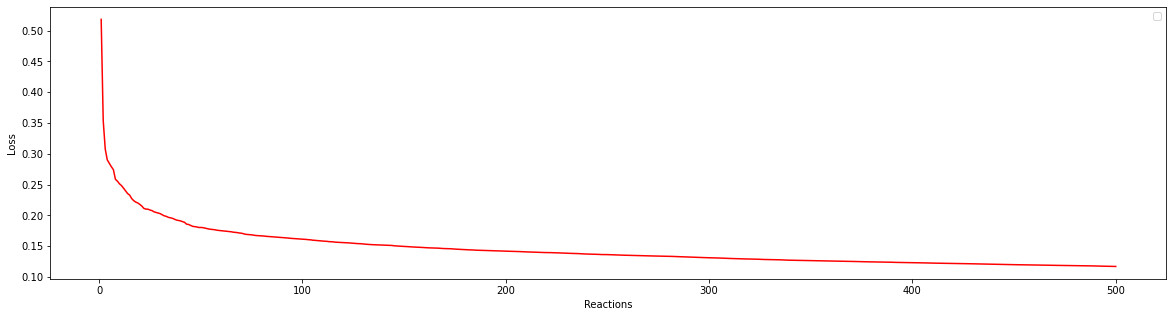

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# x = [i for i in range(1, len(loss_history)+1)]
x1 = [i for i in range(1, len(loss_history_epochs)+1)]
fig = plt.figure(figsize=(20,5))

plt.plot(x1, loss_history_epochs, color = '#ff0000')
# plt.plot(x, loss_history, label = "train", color= '#a89deb')
# plt.plot(x, val_loss_history, label = 'test', color = '#9debb3')
# plt.ylim(ymin=0.4,ymax=1.35)
plt.xlabel("Reactions")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig(BASE_PATH+"loss.png")

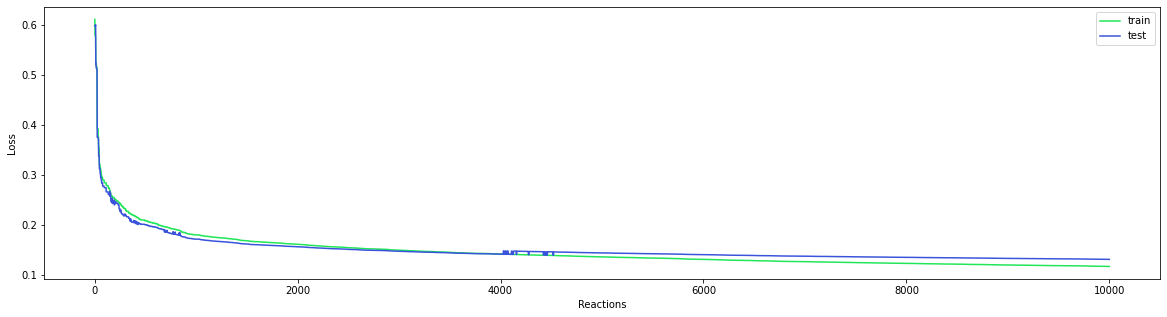

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
x = [i for i in range(1, len(loss_history)+1)]
# x1 = [50*i for i in range(1, len(loss_history_epochs)+1)]
fig = plt.figure(figsize=(20,5))

# plt.plot(x1, loss_history_epochs, color = '#ff0000', marker='o')
plt.plot(x, loss_history, label = "train", color= '#20e658')
plt.plot(x, val_loss_history, label = 'test', color = '#3954db')
# plt.ylim(ymin=0.4,ymax=1.35)
plt.xlabel("Reactions")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig(BASE_PATH+"loss.png")

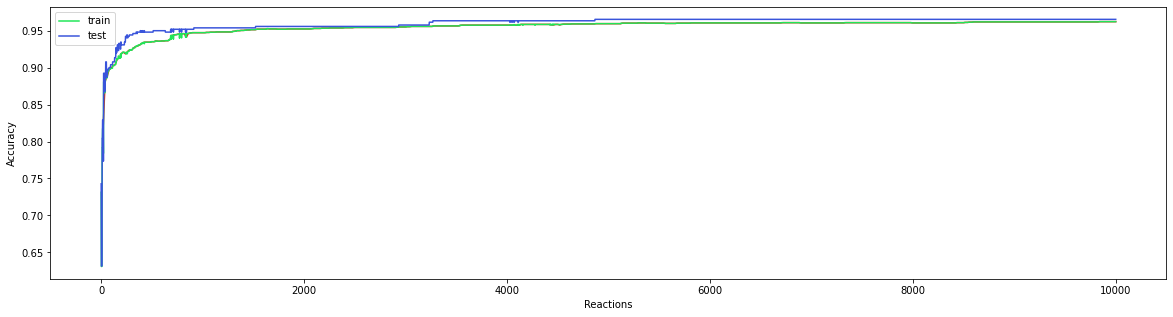

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
x = [i for i in range(1, len(acc_history)+1)]
x1 = [20*i for i in range(1, len(acc_history_epochs)+1)]

fig = plt.figure(figsize=(20,5))

plt.plot(x1, acc_history_epochs, color = '#ff0000')
plt.plot(x, acc_history, label = "train", color= '#20e658')
plt.plot(x, val_acc_history, label = 'test', color = '#3954db')
# plt.ylim(ymin=0.2,ymax=0.85)
plt.xlabel("Reactions")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig(BASE_PATH+"accuracy.png")

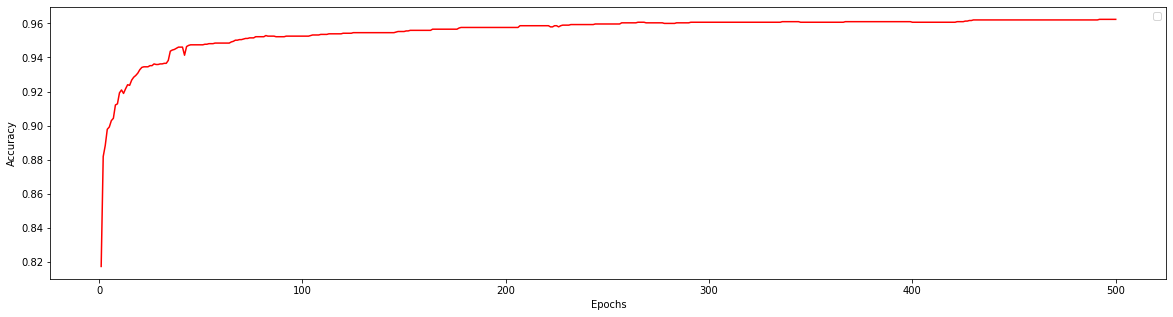

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# x = [i for i in range(1, len(acc_history)+1)]
x1 = [i for i in range(1, len(acc_history_epochs)+1)]

fig = plt.figure(figsize=(20,5))

plt.plot(x1, acc_history_epochs, color = '#ff0000')
# plt.plot(x, acc_history, label = "train", color= '#a89deb')
# plt.plot(x, val_acc_history, label = 'test', color = '#9debb3')
# plt.ylim(ymin=0.2,ymax=0.85)
# plt.xlim(xmin=0,xmax=500)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig(BASE_PATH+"accuracy.png")

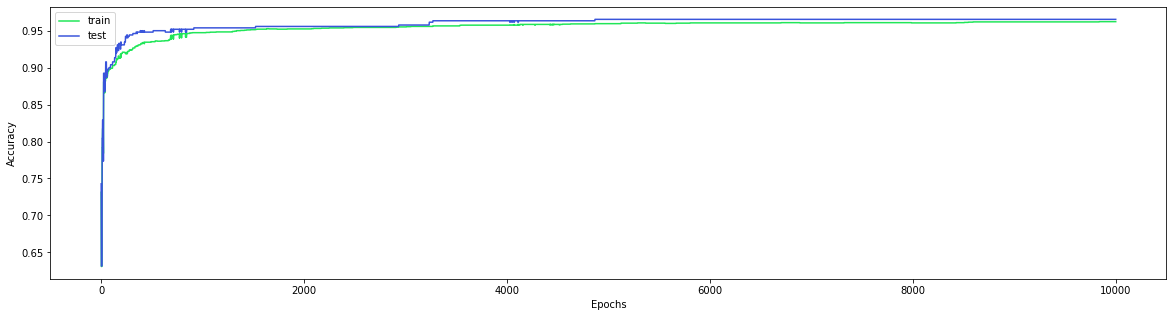

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
x = [i for i in range(1, len(acc_history)+1)]
# x1 = [50*i for i in range(1, len(acc_history_epochs)+1)]

fig = plt.figure(figsize=(20,5))

# plt.plot(x1, acc_history_epochs, color = '#ff0000', marker='o')
plt.plot(x, acc_history, label = "train", color= '#20e658')
plt.plot(x, val_acc_history, label = 'test', color = '#3954db')
# plt.ylim(ymin=0.2,ymax=0.85)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig(BASE_PATH+"accuracy.png")

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
import tensorflow_addons as tfa

In [ ]:
def best_loss_molecule():
    bm = molecule[0]
    for m in molecule:
        if m.PE < bm.PE:
            bm = m
    return bm


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [ ]:
#Training Data
def train_metrics_calculator(final_molecule):
    finetune_model.set_weights(weights=final_molecule.weights)
    logits = finetune_model(train_x)
    y_pred = logits > 0.5

    p = precision_score(train_y, y_pred)
    r = recall_score(train_y, y_pred)
    f = f1_score(train_y, y_pred)
    ck = cohen_kappa_score(train_y, y_pred)
    acc = accuracy_score(train_y, y_pred)
    loss = log_loss(train_y, logits)

    print(confusion_matrix(train_y, y_pred))
    print()
    print(f"Precision : {p}")
    print(f"Recall : {r}")
    print(f"F1 Score : {f}")
    print(f"CK Score : {ck}")
    print(f"Acc Score : {acc}")
    print(f"Loss Score : {loss}")
    print()



    import seaborn as sns
    sns.heatmap(confusion_matrix(train_y, y_pred, normalize='true'), cmap='Blues',annot=True)

In [ ]:
def test_metrics_calculator(final_molecule):
    finetune_model.set_weights(weights=final_molecule.weights)
    logits = finetune_model(test_x)
    y_pred = logits > 0.5

    p = precision_score(test_y, y_pred)
    r = recall_score(test_y, y_pred)
    f = f1_score(test_y, y_pred)
    ck = cohen_kappa_score(test_y, y_pred)
    acc = accuracy_score(test_y, y_pred)
    loss = log_loss(test_y, logits)

    print(confusion_matrix(test_y, y_pred))
    print()
    print(f"Precision : {p}")
    print(f"Recall : {r}")
    print(f"F1 Score : {f}")
    print(f"CK Score : {ck}")
    print(f"Acc Score : {acc}")
    print(f"Loss Score : {loss}")
    print()

    import seaborn as sns
    sns.heatmap(confusion_matrix(test_y, y_pred, normalize='true'), cmap='Blues',annot=True)

[[1501   44]
 [  67 1336]]

Precision : 0.9681159420289855
Recall : 0.9522451888809693
F1 Score : 0.9601149838303988
CK Score : 0.9244626736263402
Acc Score : 0.9623473541383989
Loss Score : 0.11718938175150695



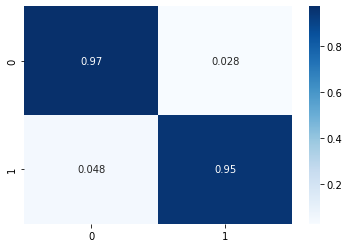

In [ ]:
m = best_loss_molecule()
train_metrics_calculator(m)

[[257   3]
 [ 15 246]]

Precision : 0.9879518072289156
Recall : 0.9425287356321839
F1 Score : 0.9647058823529412
CK Score : 0.930907965697109
Acc Score : 0.9654510556621881
Loss Score : 0.13135814290424627



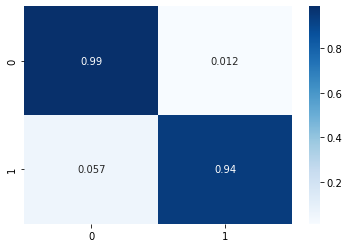

In [ ]:
test_metrics_calculator(m)

In [ ]:
save_molecules(molecule, "Model_1_momemtum_f1_ck_cro_molecule_weights_20_500")

In [ ]:
# histories = BASE_PATH + "momemtum_f1_ck_history_20_500"
# with open(histories, 'wb') as f:
#     pickle.dump(loss_history, f)
#     pickle.dump(loss_history_epochs, f)
#     pickle.dump(acc_history, f)
#     pickle.dump(acc_history_epochs, f)
#     pickle.dump(val_loss_history, f)
#     pickle.dump(val_loss_history_epochs, f)
#     pickle.dump(val_acc_history, f)
#     pickle.dump(val_acc_history_epochs, f)